In [1]:
import itertools
import warnings

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.weightstats import ttest_ind

warnings.filterwarnings("ignore")
plt.rcParams["font.family"] = "Times New Roman"
csfont = {'fontname':'Times New Roman'}

In [2]:
# windows working dir

assets_dir = "C:\\Users\\borki\\Dropbox\\twitter_nlp_project2\\assets"

### 1. Two-Tailed Tests

In this section, we are testing if the means of the two groups for each policy category are statistically significant. The null hypothesis is there is no difference in mean based on an alpha score of 0.05

In [3]:
df = pd.read_csv("vader_sentiment_tweets.csv")

In [4]:
df.head(2)

,tweet_id,username,party,tweet,clean_text,favorite_count,retweet_count,created_at,source,social_policy,...,rank,score,govtrack_cluster,progressive_cluster,govtrack_class,positive_sentiment,neutral_sentiment,negative_sentiment,compound_sentiment,sentiment_text
0,1499070296338350081,boblatta,R,The PADE Act would ban the importation of Russ...,the pade act would ban the importation of russ...,3,0,2022-03-02 17:13:04+00:00,Twitter Web App,NaN,...,#45,0.77,4,4,Far Right,0.124001,0.769001,0.107001,-0.102699,negative
1,1503834686937837572,RepThompson,D,"Last week, I held a town hall with @USRepKCast...",last week held town hall with on the impact of...,14,4,2022-03-15 20:45:03+00:00,Hootsuite Inc.,Social Policies,...,#290,0.30,1,1,Left Centrist,0.080001,0.765001,0.155001,-0.573099,negative


### Descriptive Statistics

In [5]:
desc_df = df[~df.govtrack_class.str.contains("^Centrist$", regex=True)]
desc = (
    desc_df.pivot_table(
        index="policy",
        columns="govtrack_class",
        values="compound_sentiment",
        aggfunc=["count", np.mean, np.std, np.median],
    )
    .stack(level=0)
    .round(decimals=3)
).to_csv("desc.csv")

In [6]:
political_groups = list(df.govtrack_class.unique())
political_groups.remove("Centrist")

paired_groups = list(itertools.combinations(political_groups, 2))
paired_groups

[('Far Right', 'Left Centrist'),
 ('Far Right', 'Far Left'),
 ('Far Right', 'Right Centrist'),
 ('Left Centrist', 'Far Left'),
 ('Left Centrist', 'Right Centrist'),
 ('Far Left', 'Right Centrist')]

In [7]:
def reported_value(p_value: float, alpha: float = 0.05) -> float:

    """standardize reported P values according to the following criteria:
    If P is greater than 0.01, the value is rounded to two decimal places,
    and if the rounded value is equal to the significance value,
    it is rounded to three decimal places.
    Also, values less than 0.01 are rounded off to three places.

    ------------
    params
    ------------
    p_value: float
    alpha: float, default value is 0.05

    ------------
    returns: float
    """

    if p_value < 0.001:

        rounded_p = np.round(p_value, 3)
        rounded_p = "< .001" + "***"
        p_class = "p_less_001"
        
    elif p_value < 0.01:
        rounded_p = np.round(p_value, 3)
        rounded_p = str(rounded_p) + "**"
        p_class = "p_less_01_greater_001"

    elif p_value < 0.05:
        rounded_p = np.round(p_value, 3)

        if rounded_p == alpha:
            rounded_p = np.round(p_value, 3)

        rounded_p = str(rounded_p) + "*"
        p_class = 'p_less_05_greater_01'

    else:

        rounded_p = np.round(p_value, 3)
        p_class = "p_greater_05"

    return rounded_p, p_class


def df_queries(df: pd.DataFrame, policy: str, test_group: tuple):
    """Query data from a Pandas dataframe belonging to a given policy and
    further filter the queried data into a specific political group.
    """

    df_ = df.query(f"policy == '{policy}'")  # extract data of a specific policy
    group_1 = df_.query(f"govtrack_class == '{test_group[0]}'")
    group_2 = df_.query(f"govtrack_class == '{test_group[1]}'")

    return group_1, group_2


def two_t_test(df: pd.DataFrame) -> pd.DataFrame:

    """This function computes the t-test for two independent data samples.
    In this case, compares the means of the sentiment values between two given political groups per policy.

    Ho: The averages of the sentiment values of the two independent samples are equal.

    Assumptions: Homogeneity of variances of the two groups

    :param df: pd.DataFrame, tabulated data for analysis
    :param test_group: tuple, paired political groups for comparison
    :param alpha: float, significance value

    :returns: pd. Dataframe, tabulated P-values for each policy
    """

    t_test_values = []
    rank_p_values = {}

    policies = df.policy.unique()  # list of policies in study

    for policy in policies:
        p_dist = {"p_less_001": 0,"p_less_01_greater_001": 0,"p_less_05_greater_01": 0}

        for test_group in paired_groups:

            group_1, group_2 = df_queries(df, policy, test_group)

            # compute independent t-test
            t_stat, p_value, dof = ttest_ind(
                group_1.compound_sentiment, group_2.compound_sentiment
            )

            # report standardized P-value
            p_value, p_class = reported_value(p_value)
            
            if p_class != "p_greater_05":
                p_dist[p_class] = p_dist[p_class]+1
                
            t_stat = np.round(t_stat, 3)

            p_dict = dict(
                policy=policy,
                test_group=f"{test_group[0]}-{test_group[1]}",
                T=t_stat,
                df=int(dof),
                P=p_value,
            )

            t_test_values.append(p_dict)
        rank_p_values[policy] = p_dist

    result_df = pd.DataFrame(t_test_values)
    # result_df.index = result_df["policy"]
    # result_df.drop("policy", axis=1, inplace=True)

    return result_df,rank_p_values

In [8]:
# sort the index
ind_df,rank_p_values = two_t_test(df)
ranked_policies = sorted(rank_p_values, key=lambda x: sum(rank_p_values[x].values()), reverse=True)

# sort the dataframe based on the number 
ind_df['policy'] = pd.Categorical(ind_df.policy, ordered=True, categories=ranked_policies)
ind_df = ind_df.sort_values('policy')

ind_df.index = ind_df["policy"]
ind_df.drop("policy", axis=1, inplace=True)

ind_df["df"] = ind_df["df"].apply(int)
ind_df.sort_index(inplace=True)

In [9]:
ind_df.pivot_table(index=["policy"], columns="test_group", aggfunc="first",).stack(
    level=0
).sort_index(level=[0, 1], ascending=[True, False]).to_csv("ind_test.csv")

In [10]:
colors = sns.color_palette("tab10")

### Ranking Polarization for Key Policies

In [11]:
# manual ranking of the policies

ranks = np.array([1,3,5,2,4,8,6,7,9,10,11,12])-1
resorted_policies = [ranked_policies[rank] for rank in ranks]

In [12]:
#  extract values

p_less_001 = np.array([rank_p_values[policy]['p_less_001'] for policy in resorted_policies])
p_less_01_greater_001 = np.array([rank_p_values[policy]['p_less_01_greater_001'] for policy in resorted_policies])
p_less_05_greater_01 = np.array([rank_p_values[policy]['p_less_05_greater_01'] for policy in resorted_policies])

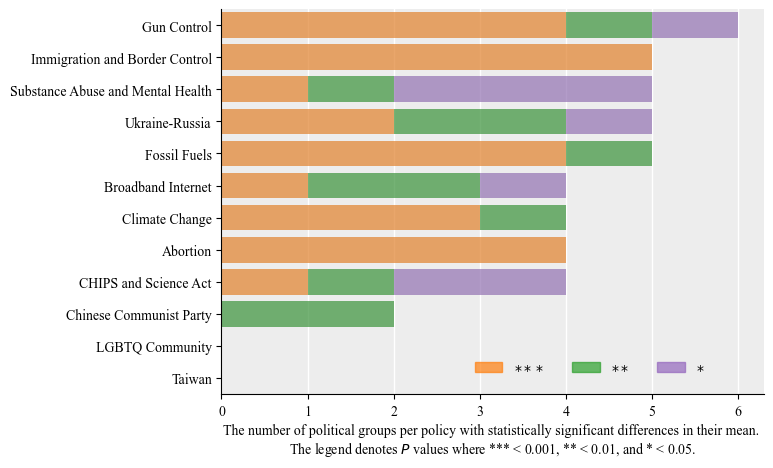

In [13]:
fig1 = plt.figure(1, figsize=(7, 5))

ax = fig1.add_subplot(1, 1, 1)

ax.set_facecolor("#D3D3D3")
ax.patch.set_alpha(0.4)

# grid lines based on major tick
ax.grid(which="major", color="w", linestyle="-", linewidth=1)

# set axis below
ax.set_axisbelow(True)
alpha = dict(alpha=0.7)

kwargs_1 = dict(left=p_less_001, color=colors[2],**alpha)
kwargs_2 = dict(left=p_less_01_greater_001+p_less_001, color=colors[4],**alpha)

sns.barplot(y=resorted_policies, x=p_less_001, color=colors[1],**alpha)
plt.yticks(fontsize=9, **csfont)
sns.barplot(y=resorted_policies, x=p_less_01_greater_001, **kwargs_1)
sns.barplot(y=resorted_policies, x=p_less_05_greater_01, **kwargs_2)

# plt.xticks(fontsize=10)
ax.set_yticklabels(
    labels=resorted_policies,
    fontsize=10,
    ha="right",
    **csfont
)

ax.set_ylabel("")
ax.set_xlabel("")
plt.xlabel("The number of political groups per policy with statistically significant differences in their mean. \nThe legend denotes $P$ values where *** < 0.001, ** < 0.01, and * < 0.05.", fontsize=10, **csfont)
# ax.set_title(f"({str_list[n]}) {titles[n]}", fontsize=10, **csfont)

# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.left.set_visible(True)
ax.spines.bottom.set_visible(True)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")

# grid lines based on minor tick
ax.grid(which="minor", color="w", linestyle="-", linewidth=1, alpha=1)

# Remove minor ticks
ax.tick_params(which="minor", bottom=False, left=False)

#     legends
patch_1 = mpatches.Patch(color=colors[1], label="$***$", **alpha)
patch_2 = mpatches.Patch(color=colors[2], label="$**$", **alpha)
patch_3 = mpatches.Patch(color=colors[4], label="$*$", **alpha)

leg1 = ax.legend(
    handles=[patch_1, patch_2, patch_3],
    bbox_to_anchor=(0.9, 0.1),
    borderaxespad=0,
    ncol=3,
    frameon=False,
)
fig1.savefig(
    assets_dir+"\\ranking.png",
    dpi=100,
    bbox_inches="tight",
)

In [105]:
# export as a csv file
ind_df.to_csv("ind_t_df.csv")

In [8]:
# test for homogeneity of variance
def levenes_test():
    """ """
    pass

### Anova (One-way and Two-Way Anova)

#### 1. Sanity Tests
Checking if the sample data is drawn from a normal distribution

In [9]:
def check_normal_dist(df, test_group: tuple):

    """checking for the normality of the data used in hypothesis testing.
    Two statistical methods are applied: the Shapiro-Wilk test and the Kolmogorov-Smirnov test.
    These tests return a test statistic and a P value.
    If the p-value is significant or less than alpha, then the data is drawn from the normal distribution.
    """

    policies = df.policy.unique()

    results = []

    for policy in policies:

        df_1, df_2 = df_queries(df, policy, test_group)

        df_ = pd.concat([df_1, df_2])

        t_test, sw_p = stats.shapiro(df_.compound_sentiment)
        D, ks_p = stats.kstest(df_.compound_sentiment, stats.norm.cdf)
        sw_p = reported_value(sw_p)
        ks_p = reported_value(ks_p)

        t_test, D, sw_p, ks_p = np.around([t_test, D, sw_p, ks_p], 3)
        results.append(
            {"policy": policy, "SW-P": sw_p, "SW t-stat": t_test, "KS-P": ks_p, "D": D}
        )

    print(f"Normality Test of Data From {test_group[0]} and {test_group[1]}")

    return pd.DataFrame(results)

In [10]:
for group in paired_groups:
    results = check_normal_dist(df, group)
    print(results)

Normality Test of Data From Far Right and Left Centrist
                               policy  SW-P  SW t-stat  KS-P      D
0             Chinese Communist Party   0.0      0.951   0.0  0.170
1                      Ukraine Russia   0.0      0.934   0.0  0.167
2      Immigration and Border Control   0.0      0.913   0.0  0.165
3                     LGBTQ Community   0.0      0.863   0.0  0.237
4   Substance Abuse and Mental Health   0.0      0.891   0.0  0.165
5                      Climate Change   0.0      0.905   0.0  0.174
6                  Broadband Internet   0.0      0.907   0.0  0.379
7                            Abortion   0.0      0.918   0.0  0.168
8                        Fossil Fuels   0.0      0.949   0.0  0.169
9                         Gun Control   0.0      0.854   0.0  0.249
10                             Taiwan   0.0      0.899   0.0  0.214
11                  Chips Science Act   0.0      0.888   0.0  0.355
Normality Test of Data From Far Right and Right Centrist
   

In [73]:
def one_way_anova(df: pd.DataFrame) -> pd.DataFrame:

    """Determines if there is any statistically significant difference
    between the means of two or more independent groups of data. The political
    groups are paired, and the means of the sentiments are compared in each policy category.

    H0: There is no statistically significant difference between the means of
    the independent groups (m1 = m2 = m3 =... = mk) where k is the number of groups.

    Assumptions:

    - The samples are independent.
    - Each sample is from a normally distributed population.
    - Homogeneity of variance

    :param df: pd.DataFrame, tabulated data for analysis
    :param test_group: tuple, paired political groups for comparison

    :returns: pd. Dataframe, tabulated P-values for each policy
    """

    policies = df.policy.unique()
    test_result = []
    tables = []

    for policy in policies:

        for test_group in paired_groups:

            group_1, group_2 = df_queries(df, policy, test_group)
            df_test = pd.concat([group_1, group_2])

            f_stat, p_value = stats.f_oneway(
                group_1.compound_sentiment, group_2.compound_sentiment
            )

            mod = ols("compound_sentiment ~ C(govtrack_class)", data=df_test).fit()

            table = anova_lm(mod, typ=2)
            tables.append(table)

            p_value = reported_value(p_value)
            f_stat = np.round(f_stat, 3)

            p_dict = dict(
                policy=policy,
                test_group=f"{test_group[0]}-{test_group[1]}",
                P=p_value,
                F=f_stat,
            )

            test_result.append(p_dict)

    result_df = pd.DataFrame(test_result)
    result_df.index = result_df["policy"]
    result_df.drop("policy", axis=1, inplace=True)
    # print(summary_col(models[:5], stars=True, float_format="%0.2f"))

    return result_df, tables

In [229]:
df_one_way, tables = one_way_anova(df)
df_one_way

,test_group,P,F
policy,,,
Chinese Communist Party,Far Right-Left Centrist,0.003,8.604
Chinese Communist Party,Far Right-Right Centrist,0.820,0.050
Chinese Communist Party,Far Right-Far Left,0.610,0.259
Chinese Communist Party,Left Centrist-Right Centrist,0.004,8.106
Chinese Communist Party,Left Centrist-Far Left,0.052,3.806
...,...,...,...
Chips Science Act,Far Right-Right Centrist,0.052,3.861
Chips Science Act,Far Right-Far Left,0.030,5.006
Chips Science Act,Left Centrist-Right Centrist,0.001,10.785


In [230]:
(pd.concat(tables)).round(3)

,sum_sq,df,F,PR(>F)
C(govtrack_class),2.580,1.0,8.604,0.003
Residual,626.011,2088.0,NaN,NaN
C(govtrack_class),0.015,1.0,0.050,0.824
Residual,1275.988,4298.0,NaN,NaN
C(govtrack_class),0.076,1.0,0.259,0.611
...,...,...,...,...
Residual,73.411,372.0,NaN,NaN
C(govtrack_class),0.950,1.0,5.052,0.025
Residual,63.921,340.0,NaN,NaN
C(govtrack_class),0.036,1.0,0.157,0.693


In [13]:
# export to a csv file
df_one_way.to_csv("one_way_anova.csv")

## Two-Way Anova

### Grouping the Left and Right Categories

In [21]:
df_two_anova = df.copy()
df_two_anova["general_class"] = df_two_anova["govtrack_class"].map(
    {
        "Far Left": "Left",
        "Far Right": "Right",
        "Left Centrist": "Left",
        "Right Centrist": "Right",
    }
)

df_two_anova = df_two_anova.query("general_class == 'Left' | general_class == 'Right'")

In [22]:
# fit data into the model

multiple_variables = ols(
    "compound_sentiment ~ C(policy) + C(general_class) + C(policy): C(general_class) ",
    data=df_two_anova,
).fit()

In [ ]:
print(
    summary_col(
        [multiple_variables, multiple_variables], stars=True, float_format="%0.2f"
    )
)

In [32]:
mod = ols("compound_sentiment ~ general_class", data=df_two_anova).fit()

In [33]:
print(summary_col([mod], stars=True, float_format="%0.2f"))


                       compound_sentiment
-----------------------------------------
Intercept              0.07***           
                       (0.00)            
general_class[T.Right] -0.17***          
                       (0.00)            
R-squared              0.02              
R-squared Adj.         0.02              
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [24]:
# type two Anova

sms.anova_lm(multiple_variables, typ=2)

,sum_sq,df,F,PR(>F)
C(policy),2547.961543,11.0,693.294198,0.000000e+00
C(general_class),295.418905,1.0,884.210497,4.759454e-193
C(policy):C(general_class),789.447419,11.0,214.806741,0.000000e+00
Residual,22484.245705,67297.0,NaN,NaN


## Multiple Testing -  2 Way Anova

In [38]:
def multiple_comparisons(df: pd.DataFrame):
    """Run multiple t tests."""
    p_values = []

    policy_pairs = list(itertools.combinations(list(df["policy"].unique()), 2))
    p_values = []

    for policy_pair in policy_pairs:

        df_pol = df.loc[(df.policy == policy_pair[0]) | (df.policy == policy_pair[1])]
        group_ps = {}

        for group in paired_groups:

            df_pol_cluster = df_pol.loc[
                (df_pol.govtrack_class == group[0])
                | (df_pol.govtrack_class == group[1])
            ]

            multiple_variables = ols(
                "compound_sentiment ~ C(policy) + C(govtrack_class) + C(policy): C(govtrack_class)",
                data=df_pol_cluster,
            ).fit()

            p = sms.anova_lm(multiple_variables, typ=2).loc[
                "C(policy):C(govtrack_class)"
            ]["PR(>F)"]

            p_value = reported_value(p)

            group_ps[f"{group[0]}-{group[1]}"] = p_value
        p_values.append(group_ps)

    return policy_pairs, p_values

In [39]:
policy_pairs, p_values = multiple_comparisons(df)

multiple_df = pd.DataFrame(p_values)
multiple_df.index = [f"{group[0]}-{group[1]}" for group in policy_pairs]

In [40]:
multiple_df

,Far Right-Left Centrist,Far Right-Right Centrist,Far Right-Far Left,Left Centrist-Right Centrist,Left Centrist-Far Left,Right Centrist-Far Left
Chinese Communist Party-Ukraine Russia,0.47,0.002,0.150,0.200,0.44,0.930
Chinese Communist Party-Immigration and Border Control,0.00,0.410,0.000,0.000,0.60,0.000
Chinese Communist Party-LGBTQ Community,0.53,0.660,0.330,0.620,0.14,0.190
Chinese Communist Party-Substance Abuse and Mental Health,0.16,0.046,0.049,0.820,0.43,0.440
Chinese Communist Party-Climate Change,0.30,0.001,0.060,0.040,0.28,0.800
...,...,...,...,...,...,...
Fossil Fuels-Taiwan,0.22,0.010,0.550,0.650,0.21,0.090
Fossil Fuels-Chips Science Act,0.07,0.430,0.280,0.180,0.58,0.640
Gun Control-Taiwan,0.04,0.054,0.020,0.001,0.46,0.002
Gun Control-Chips Science Act,0.00,0.350,0.005,0.000,0.22,0.020


In [41]:
multiple_df.to_csv("multiple_anova.csv")

In [89]:
# interaction plot

# interaction_plot(
#     x = df_two_anova["general_class"],
#     trace = df_two_anova["policy"],
#     response = df_two_anova["compound_sentiment"],
# )
# plt.xticks(rotation=90)
# plt.show()